<a href="https://colab.research.google.com/github/SemanticComputing/parliamentsampo-mention-networks/blob/main/Semparl_mentions_timelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mentions during parliamentary sessions

In [ ]:
!pip install rdflib SPARQLWrapper
%matplotlib inline

In [ ]:
import codecs

from collections import defaultdict, OrderedDict, Counter
from datetime import datetime, timedelta, date
from dateutil.relativedelta import relativedelta
from itertools import product, combinations, chain


from matplotlib import pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors

import networkx as nx
from networkx.algorithms import community
import numpy    as np

import pandas   as pd
import rdflib as rdflib
from rdflib.namespace import XSD, RDF, RDFS, Namespace, SKOS, OWL
import re
from scipy.interpolate import interp1d
from scipy.signal import convolve2d
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer, minmax_scale
from SPARQLWrapper import SPARQLWrapper, JSON, POST
import sys
from typing import Dict, List, Set, Tuple, Type, Union

import IPython
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [ ]:
def checkDate(v):
  try:
    d = datetime.strptime(v, '%Y-%m-%dT%H:%M:%S').date()
  except ValueError:
    '''
    cases e.g. 29th february of a non-loop year
    '''
    m = re.match(r'(\d{4})-(\d{2})-(\d{2})', v)
    d = datetime(int(m.groups()[0]), int(m.groups()[1]), 28).date()
  return d

DATATYPECONVERTERS = {
      str(XSD.integer):  int,
      str(XSD.decimal):  float,
      str(XSD.date):     lambda v: datetime.strptime(v, '%Y-%m-%d').date(),
      str(XSD.dateTime): checkDate
  }

def convertDatatype(obj):
  return DATATYPECONVERTERS.get(obj.get('datatype'), str)(obj.get('value'))

def convertDatatypes(results):
    res = results["results"]["bindings"]
    return [dict([(k, convertDatatype(v)) for k,v in r.items()]) for r in res]

In [ ]:
ENDPOINT = "http://ldf.fi/semparl/sparql"

PREFIXES = """
PREFIX bioc: <http://ldf.fi/schema/bioc/>
PREFIX crm: <http://erlangen-crm.org/current/>
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX districts: <http://ldf.fi/semparl/groups/districts/>
PREFIX event: <http://ldf.fi/semparl/event/>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX groups: <http://ldf.fi/semparl/groups/>
PREFIX label: <http://ldf.fi/semparl/label/>
PREFIX occupations: <http://ldf.fi/semparl/occupations/>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX people: <http://ldf.fi/semparl/people/>
PREFIX places: <http://ldf.fi/semparl/places/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX roles: <http://ldf.fi/semparl/roles/>
PREFIX schema: <http://schema.org/>
PREFIX semparls: <http://ldf.fi/schema/semparl/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX times: <http://ldf.fi/semparl/times/>
PREFIX eterms: <http://ldf.fi/semparl/times/electoral-terms/>
PREFIX titles: <http://ldf.fi/semparl/titles/>
PREFIX xml: <http://www.w3.org/XML/1998/namespace>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX semparl_linguistics: <http://ldf.fi/schema/semparl/linguistics/>
"""

## Mentions by gender


Query the amount of speeches during parliamentary sessions where male/female MP has mentioned male/female MPs

In [ ]:
q = """
SELECT DISTINCT ?parls ?gender1 ?gender2 (COUNT(DISTINCT ?s) AS ?speeches) {

    ?s a semparls:Subcorpus5 .  #Puheet valtiopäiviltä 2015-nykyhetki
    ?s semparls:speechType ?type .
    FILTER (?type != <http://ldf.fi/semparl/speechtypes/PuhemiesPuheenvuoro>) .    # Filter the speeches of Speaker of Parliament
    ?s dct:language <http://id.loc.gov/vocabulary/iso639-2/fin> .                  # Take only speeches given in Finnish into account
    ?s semparls:plenarySession/semparls:parliamentarySession ?session .
    ?session skos:prefLabel ?parls .
    FILTER(LANG(?parls)='fi')
    ?session semparls:electoralTerm ?eterm .

    # Check that target was also MP during same electoral term
    ?s semparl_linguistics:referenceToPerson/skos:relatedMatch ?target .
    ?target bioc:bearer_of/crm:P11i_participated_in ?event .
    ?event a semparls:ParliamentaryGroupMembership .
    ?event crm:P10_falls_within ?eterm .

    ?target bioc:has_gender ?gender2 .
    ?s semparls:speaker ?source .
    ?s semparls:party ?party .
    ?source bioc:has_gender ?gender1 .

} GROUP BY ?parls ?gender1 ?gender2

"""
sparql = SPARQLWrapper(ENDPOINT)

sparql.setReturnFormat(JSON)
sparql.setMethod(POST)

sparql.setQuery(PREFIXES + q)
results = sparql.query().convert()

vars = results['head']['vars']

res_nodes = convertDatatypes(results)
print(len(res_nodes))


32


In [ ]:
parls_mentions = {}
for ob in res_nodes:
  key = int(ob['parls'].split(" ")[-1])
  if key not in parls_mentions:
    parls_mentions[key] = {'ff':0, 'fm':0, 'mm':0, 'mf':0}
  if ob['gender1'] == ob['gender2'] == 'http://schema.org/Female':
    #ob['link'] = 'ff'
    parls_mentions[key]['ff'] += ob['speeches']
  elif ob['gender1'] == ob['gender2'] == 'http://schema.org/Male':
    #ob['link'] = 'mm'
    parls_mentions[key]['mm'] += ob['speeches']
  elif ob['gender1'] == 'http://schema.org/Female' and ob['gender2'] == 'http://schema.org/Male':
    #ob['link'] = 'fm'
    parls_mentions[key]['fm'] += ob['speeches']
  elif ob['gender2'] == 'http://schema.org/Female' and ob['gender1'] == 'http://schema.org/Male':
    #ob['link'] = 'mf'
    parls_mentions[key]['mf'] += ob['speeches']
  else:
    print(ob['gender1'], ob['gender1'])


parls_mentions

{2019: {'ff': 824, 'fm': 946, 'mm': 1805, 'mf': 1047},
 2017: {'ff': 1043, 'fm': 1700, 'mm': 2993, 'mf': 1524},
 2015: {'ff': 781, 'fm': 1158, 'mm': 2056, 'mf': 907},
 2021: {'ff': 1405, 'fm': 1366, 'mm': 2367, 'mf': 1620},
 2018: {'ff': 1307, 'fm': 1880, 'mm': 3607, 'mf': 1729},
 2016: {'ff': 1031, 'fm': 1808, 'mm': 3136, 'mf': 1550},
 2022: {'ff': 254, 'fm': 293, 'mm': 661, 'mf': 368},
 2020: {'ff': 1336, 'fm': 1390, 'mm': 2355, 'mf': 1599}}

In [ ]:
speeches_m = 0
speeches_f = 0
speeches_t = 0

for p in parls_mentions:
  pf = parls_mentions[p]['ff'] + parls_mentions[p]['fm']
  pm = parls_mentions[p]['mm'] + parls_mentions[p]['mf']
  speeches_f += pf
  speeches_m += pm
  speeches_t += pf + pm
  parls_mentions[p]['total_f'] = pf
  parls_mentions[p]['total_m'] = pm
  parls_mentions[p]['total'] = pf + pm

  tof = parls_mentions[p]['ff'] + parls_mentions[p]['mf']
  tom = parls_mentions[p]['mm'] + parls_mentions[p]['fm']

  parls_mentions[p]['mento_f'] = tof
  parls_mentions[p]['mento_m'] = tom
  #parls_mentions[p]['mentotal'] = tof + tom # same as total

print("Mentions by women:", speeches_f)
print("Mentions by men:", speeches_m)
print("Total mentions:", speeches_t)

Mentions by women: 18522
Mentions by men: 29324
Total mentions: 47846


In [ ]:
q = """
# Number of speeches by gender
SELECT DISTINCT ?parls ?gender1 (COUNT(DISTINCT ?s) AS ?speeches) {

    ?s a semparls:Subcorpus5 .  #Puheet valtiopäiviltä 2015-nykyhetki
    ?s semparls:speechType ?type .
    FILTER (?type != <http://ldf.fi/semparl/speechtypes/PuhemiesPuheenvuoro>) .
    ?s dct:language <http://id.loc.gov/vocabulary/iso639-2/fin> .
    ?s semparls:plenarySession/semparls:parliamentarySession ?session .
    ?session skos:prefLabel ?parls .
    FILTER(LANG(?parls)='fi')
    ?session semparls:electoralTerm ?eterm .

    ?s semparls:speaker ?source .
    ?s semparls:party ?party .
    ?source bioc:has_gender ?gender1 .

} GROUP BY ?parls ?gender1

"""
sparql = SPARQLWrapper(ENDPOINT)

sparql.setReturnFormat(JSON)
sparql.setMethod(POST)

sparql.setQuery(PREFIXES + q)
results = sparql.query().convert()

vars = results['head']['vars']

res_nodes = convertDatatypes(results)
print(len(res_nodes))


16


In [ ]:
speeches_m = 0
speeches_f = 0
speeches_t = 0


for ob in res_nodes:
  key = int(ob['parls'].split(" ")[-1])
  if ob['gender1'] == 'http://schema.org/Female':
    parls_mentions[key]['speeches_f'] = ob['speeches']
    speeches_f += ob['speeches']
  else:
    parls_mentions[key]['speeches_m'] = ob['speeches']
    speeches_m += ob['speeches']

for key in parls_mentions:
  parls_mentions[key]['speeches_t'] = parls_mentions[key]['speeches_f'] + parls_mentions[key]['speeches_m']


print("Speeches by women:", speeches_f)
print("Speeches by men:", speeches_m)
print("Total speeches:", speeches_f+speeches_m)

Speeches by women: 40988
Speeches by men: 52054
Total speeches: 93042


In [ ]:
# Now parls_speeches dictionary of parliamentary session dictionaries, where
# speeches_t = total number of speeches
# speeches_f = total number of speeches given by females
# speeches_m = total number of speeches given by males
# total      = total number of mentions made during parliamentary session
# total_f    = total number of mentions made by women
# total_m    = total number of mentions made by men
# mento_f    = total number of mentions to women
# mento_m    = total number of mentions to men
# ff         = mentions from women to women
# fm         = mentions from women to men
# mm         = mentions from men to men
# mf         = mentions from men to women
parls_mentions

{2019: {'ff': 824,
  'fm': 946,
  'mm': 1805,
  'mf': 1047,
  'total_f': 1770,
  'total_m': 2852,
  'total': 4622,
  'mento_f': 1871,
  'mento_m': 2751,
  'speeches_m': 3889,
  'speeches_f': 2991,
  'speeches_t': 6880},
 2017: {'ff': 1043,
  'fm': 1700,
  'mm': 2993,
  'mf': 1524,
  'total_f': 2743,
  'total_m': 4517,
  'total': 7260,
  'mento_f': 2567,
  'mento_m': 4693,
  'speeches_m': 7689,
  'speeches_f': 5761,
  'speeches_t': 13450},
 2015: {'ff': 781,
  'fm': 1158,
  'mm': 2056,
  'mf': 907,
  'total_f': 1939,
  'total_m': 2963,
  'total': 4902,
  'mento_f': 1688,
  'mento_m': 3214,
  'speeches_m': 4804,
  'speeches_f': 3782,
  'speeches_t': 8586},
 2021: {'ff': 1405,
  'fm': 1366,
  'mm': 2367,
  'mf': 1620,
  'total_f': 2771,
  'total_m': 3987,
  'total': 6758,
  'mento_f': 3025,
  'mento_m': 3733,
  'speeches_m': 6717,
  'speeches_f': 5576,
  'speeches_t': 12293},
 2018: {'ff': 1307,
  'fm': 1880,
  'mm': 3607,
  'mf': 1729,
  'total_f': 3187,
  'total_m': 5336,
  'total': 852

[0.4279766860949209, 0.4024640657084189, 0.3892573806736897, 0.4076166798508306, 0.46412959629724865, 0.3620848708487085, 0.3523894595801697]
[0.18880099916736054, 0.19892197125256675, 0.1982052282481467, 0.19538930952650016, 0.26922087940344563, 0.24584870848708487, 0.241179097811523]
[0.20650449497620307, 0.17654109589041095, 0.181044957472661, 0.19851154313487243, 0.2754931461049816, 0.2325095718760877, 0.25197274031563843]
[0.3061872025383395, 0.3095890410958904, 0.2950876583926402, 0.28554070473876064, 0.3162821798729522, 0.2419074138531152, 0.24497847919655666]


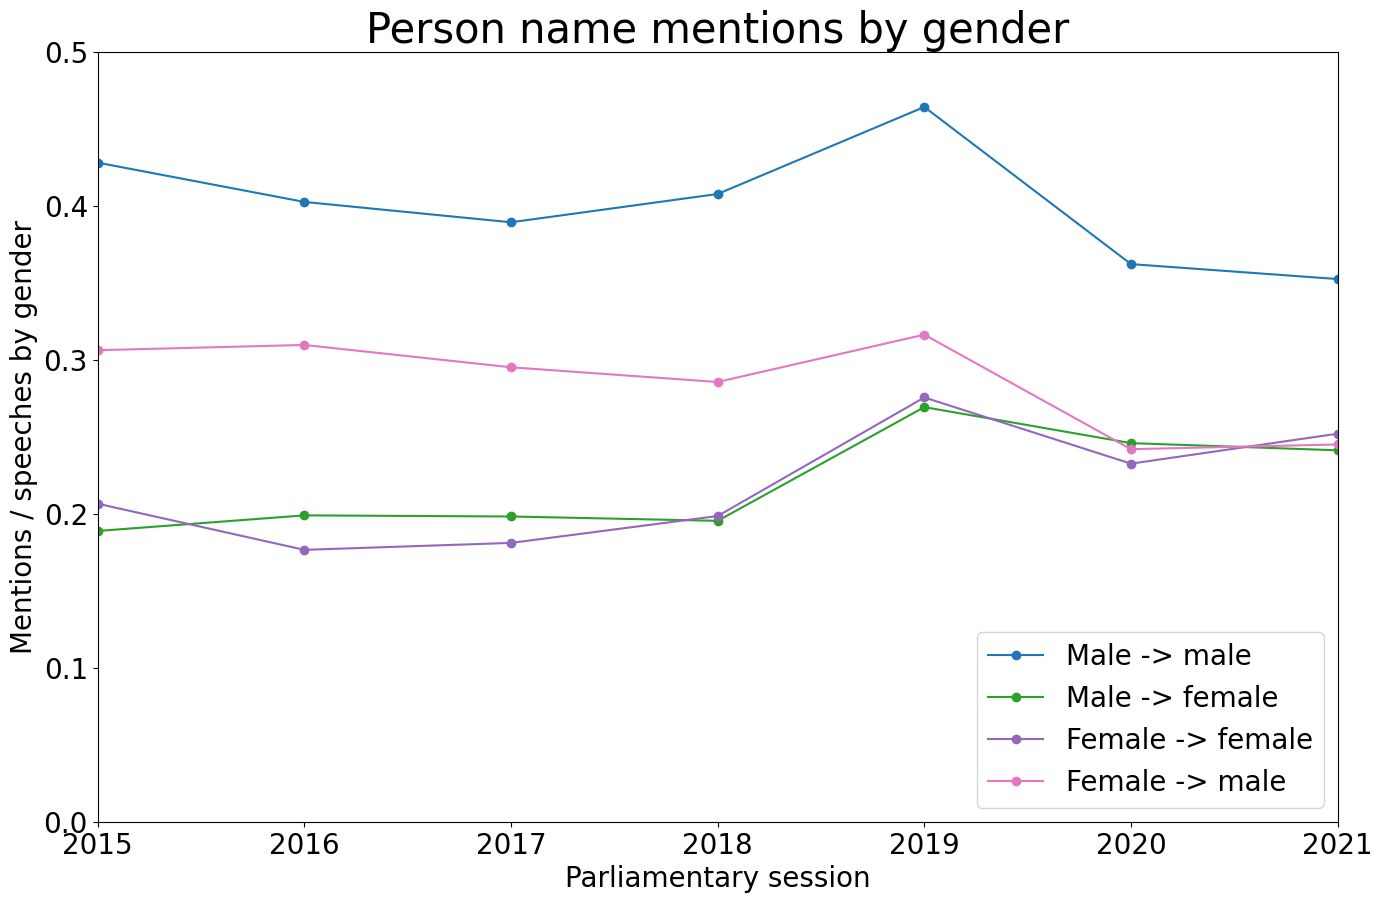

In [ ]:
NUM_COLORS = 6
cm = plt.get_cmap('tab20')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

x = [key for key in sorted(parls_mentions)][:-1]
ys = []

title = 'Person name mentions by gender'
labels = ['Male -> male', 'Male -> female', 'Female -> female', 'Female -> male', 'Male total', 'Female total']
x_label = 'Parliamentary session'
y_label = 'Mentions / speeches by gender'
ys.append([ parls_mentions[key]['mm']/parls_mentions[key]['speeches_m'] for key in x])
ys.append([ parls_mentions[key]['mf']/parls_mentions[key]['speeches_m'] for key in x])

ys.append([ parls_mentions[key]['ff']/parls_mentions[key]['speeches_f'] for key in x])
ys.append([ parls_mentions[key]['fm']/parls_mentions[key]['speeches_f'] for key in x])

#ys.append([ parls_mentions[key]['total_m']/parls_mentions[key]['speeches_m'] for key in x])
#ys.append([ parls_mentions[key]['total_f']/parls_mentions[key]['speeches_f'] for key in x])





fig = plt.figure(figsize=[16.0, 10.0])

ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS)])

for y in ys:
  print(y)
  ax.plot(x, y, marker='o')

ax.autoscale(enable=True, axis='x', tight=True)
#ax.legend(labels=labels,prop={'size': 20},loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(labels=labels, loc='lower right',prop={'size': 20})
ax.set_title(title, fontsize=30)
ax.set_xlabel(x_label, fontsize=20)
ax.set_ylabel(y_label, fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_ylim([0.0, 0.5])
plt.show()

[0.3743303051479152, 0.3626760563380282, 0.34892193308550185, 0.3555368366487397, 0.3998546511627907, 0.3057142857142857, 0.30366875457577486]
[0.3450966689960401, 0.34375, 0.3358364312267658, 0.34575260804769004, 0.4145348837209302, 0.32277551020408163, 0.3243309200357927]
[0.19659911483810855, 0.18933392018779344, 0.1908550185873606, 0.19672131147540983, 0.2719476744186046, 0.23959183673469386, 0.24607500203367771]
[0.2258327509899837, 0.2082599765258216, 0.20394052044609665, 0.20650554007645955, 0.25726744186046513, 0.22253061224489795, 0.22541283657365982]


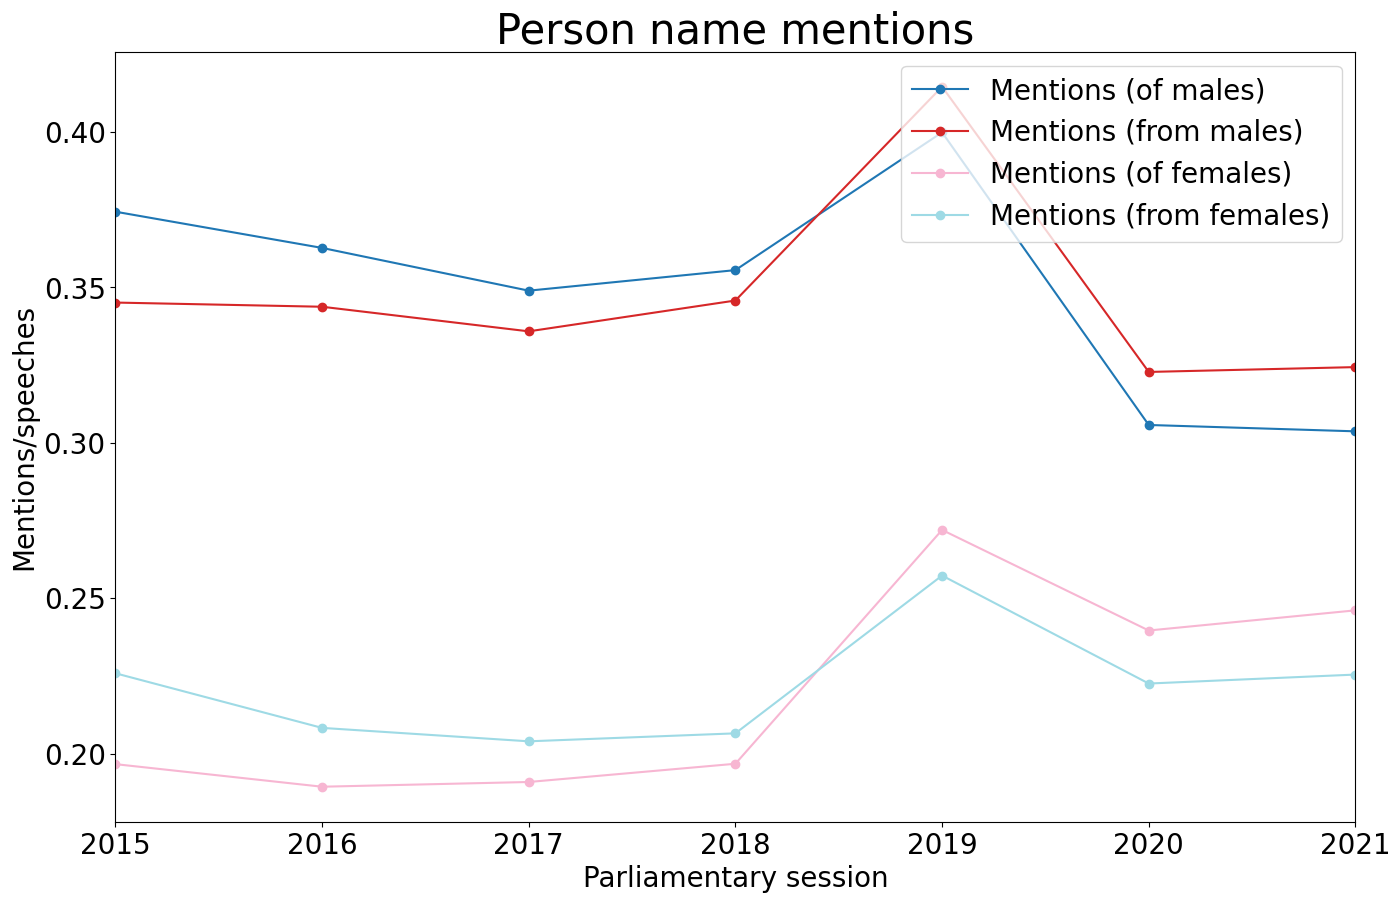

In [ ]:
NUM_COLORS = 4
cm = plt.get_cmap('tab20')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

x = [key for key in sorted(parls_mentions)][:-1]
ys = []

title = 'Person name mentions'
labels = ['Mentions (of males)', 'Mentions (from males)', 'Mentions (of females)', 'Mentions (from females)']
x_label = 'Parliamentary session'
y_label = 'Mentions/speeches'

#ys.append([ parls_mentions[key]['speeches_m'] for key in x])
ys.append([ parls_mentions[key]['mento_m']/parls_mentions[key]['speeches_t'] for key in x])
ys.append([ parls_mentions[key]['total_m']/parls_mentions[key]['speeches_t'] for key in x])

#ys.append([ parls_mentions[key]['speeches_f'] for key in x])
ys.append([ parls_mentions[key]['mento_f']/parls_mentions[key]['speeches_t'] for key in x])
ys.append([ parls_mentions[key]['total_f']/parls_mentions[key]['speeches_t'] for key in x])

#ys.append([ parls_mentions[key]['tm']/parls_mentions[key]['speeches_m'] for key in x])
#ys.append([ parls_mentions[key]['tf']/parls_mentions[key]['speeches_f'] for key in x])





fig = plt.figure(figsize=[16.0, 10.0])

ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS)])

for y in ys:
  print(y)
  ax.plot(x, y, marker='o')

ax.autoscale(enable=True, axis='x', tight=True)
#ax.legend(labels=labels,prop={'size': 20},loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(labels=labels, loc='upper right',prop={'size': 20})
ax.set_title(title, fontsize=30)
ax.set_xlabel(x_label, fontsize=20)
ax.set_ylabel(y_label, fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.show()

# Number of mentions in speeches

In [ ]:
sparql = SPARQLWrapper(ENDPOINT)
# eterms:e_2015-04-22-2019-04-16
filter = """
# Filter that referenced person (?target) is a current MP or minister
  ?sp semparls:plenarySession/semparls:parliamentarySession/semparls:electoralTerm eterms:e_2015-04-22-2019-04-16 .
  ?target bioc:bearer_of/crm:P11i_participated_in ?event .
  ?event a semparls:ParliamentaryGroupMembership .
  ?event crm:P10_falls_within eterms:e_2015-04-22-2019-04-16 .
"""
sparql.setQuery(PREFIXES+"""

SELECT DISTINCT ?sp (COUNT(DISTINCT ?target) AS ?weight)  WHERE {

  ?sp a semparls:Subcorpus5 .
  ?sp semparls:speechType ?type .
  FILTER (?type != <http://ldf.fi/semparl/speechtypes/PuhemiesPuheenvuoro>) .
  ?sp dct:language <http://id.loc.gov/vocabulary/iso639-2/fin> .                  # Suomen kieliset puheet

  ?sp semparl_linguistics:referenceToPerson/skos:relatedMatch ?target .
""" + filter + """

  ?sp semparls:speaker ?source .
  FILTER (?source != ?target)

}  GROUP BY ?sp """)

sparql.setReturnFormat(JSON)
sparql.setMethod(POST)

results = sparql.query().convert()
results2 = convertDatatypes(results)
mentions = {}

total_mentions = 0
for i in range(1,20):
  mentions[i] = 0
for ob in results2:
  total_mentions += ob['weight']
  if ob['weight'] > 15:
    print(ob['weight'], ob['sp'])
  if ob['weight'] not in mentions:
    mentions[ob['weight']] = 1
  else:
    mentions[ob['weight']] += 1

print(len(results2))
print(total_mentions)
print(mentions)

22 http://ldf.fi/semparl/speeches/s2017_1_073_050
21 http://ldf.fi/semparl/speeches/s2017_1_019_084
16 http://ldf.fi/semparl/speeches/s2018_1_175_068
24188
37243
{1: 16130, 2: 5352, 3: 1662, 4: 552, 5: 214, 6: 110, 7: 49, 8: 47, 9: 33, 10: 13, 11: 8, 12: 7, 13: 5, 14: 2, 15: 1, 16: 1, 17: 0, 18: 0, 19: 0, 22: 1, 21: 1}


In [ ]:
# Number of speeches given during parliamentary sessions 2015-2021 (Swedish speeches and speeches of the Speaker excluded)
SPEECHES = 51165 #85663
nm_speeches = SPEECHES - len(results2)

In [ ]:
summa = 0
for key in mentions:
  summa += key * mentions[key]
print("Mean number of mentions in speeches that contain mentions:", summa / len(results2))
print("Mean number of mentions in all speeches:", summa / SPEECHES)

Mean number of mentions in speeches that contain mentions: 1.5397304448486853
Mean number of mentions in all speeches: 0.727899931593863


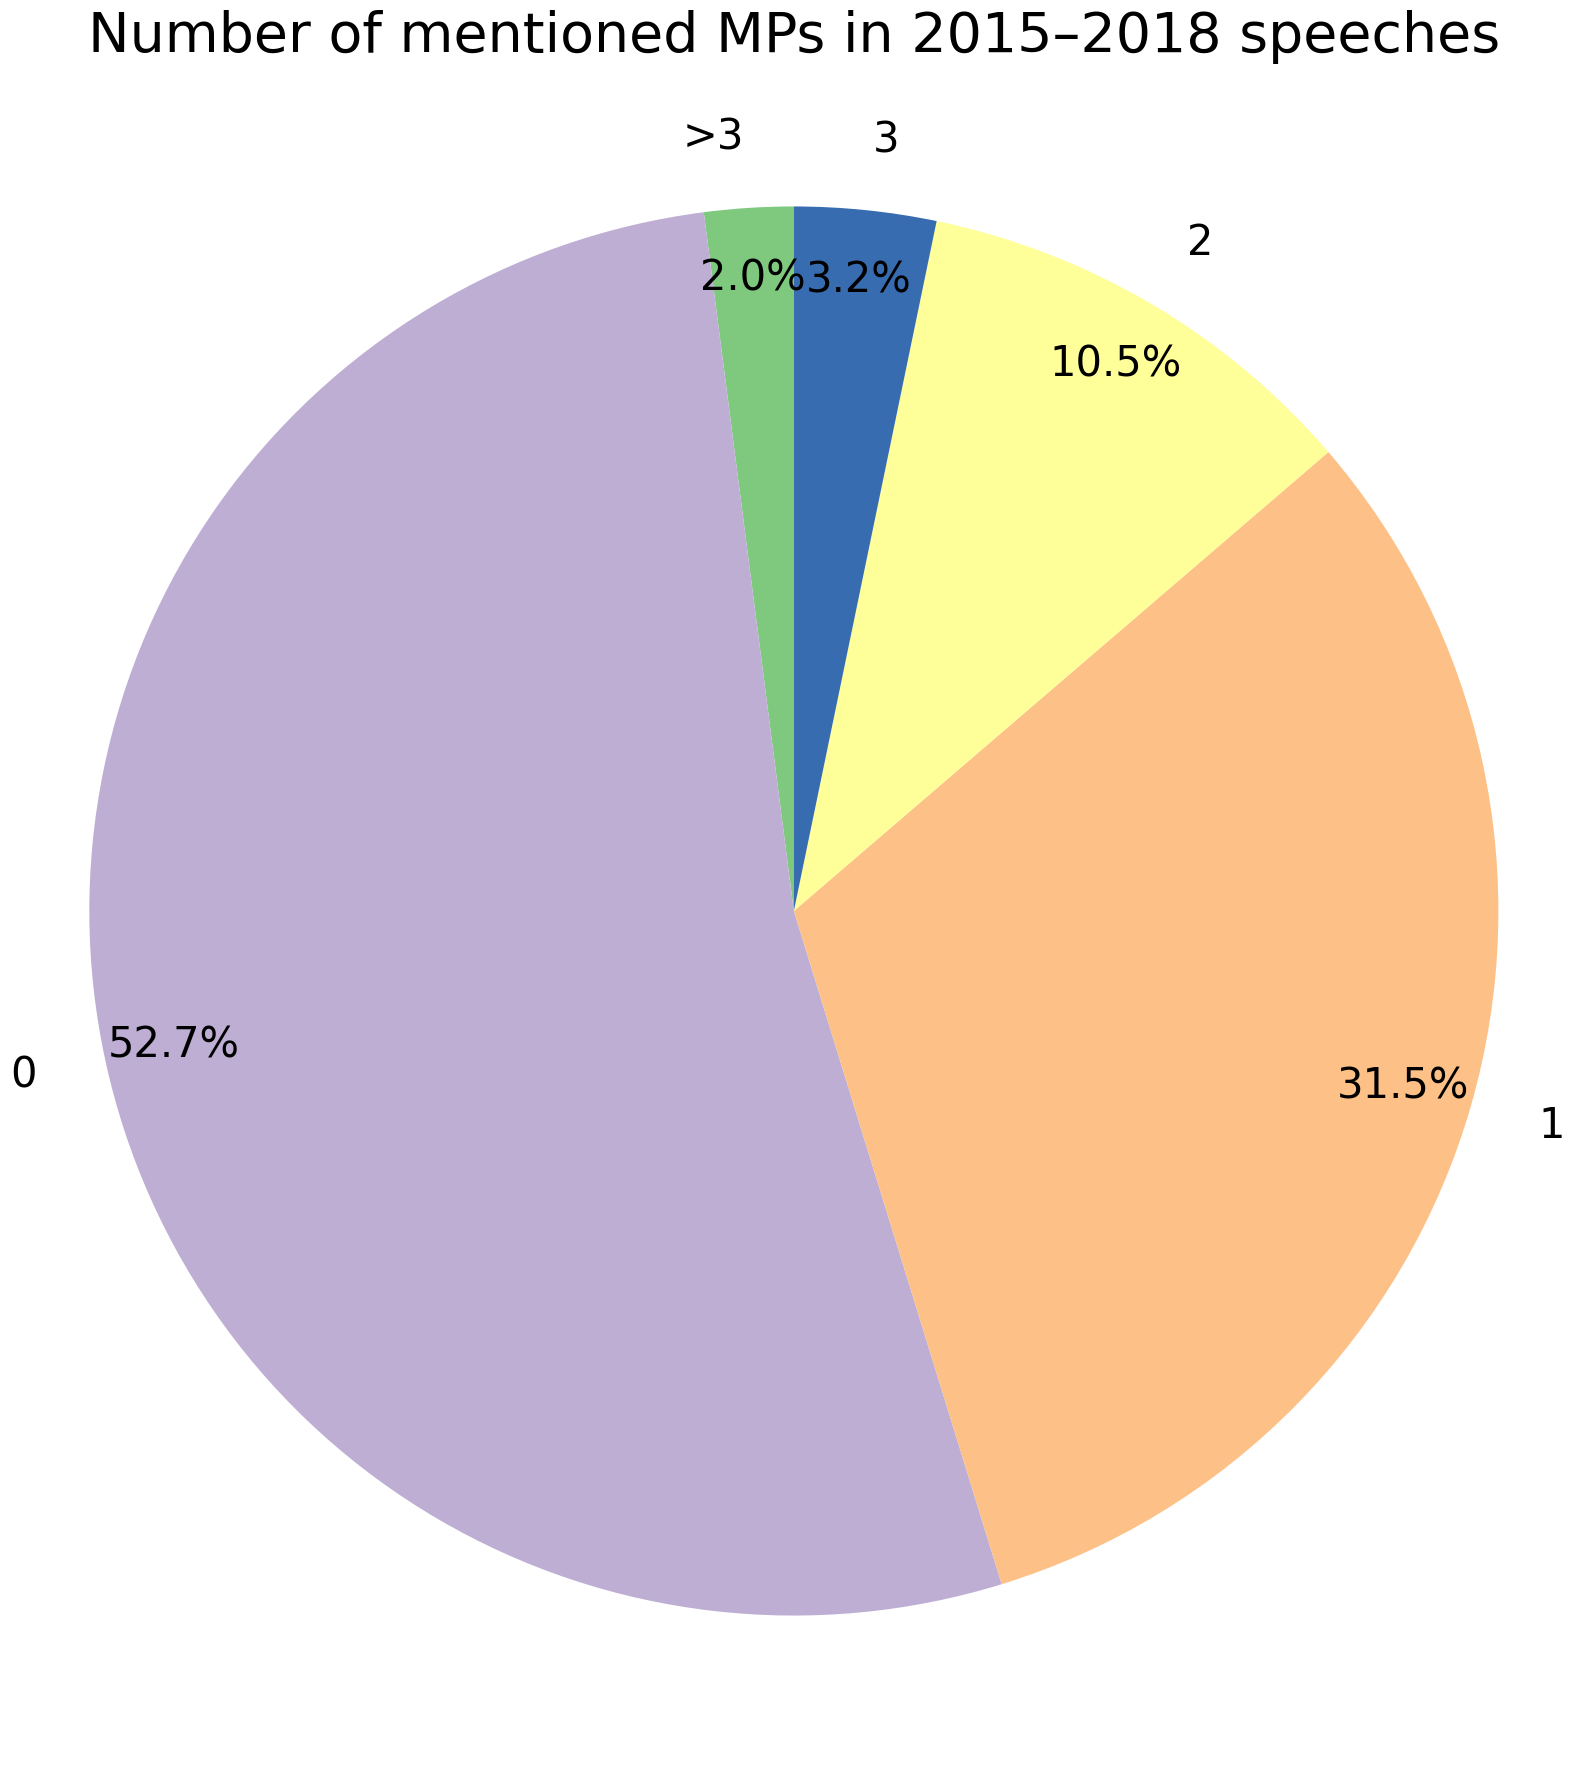

In [ ]:
NUM_COLORS = 9
cm = plt.get_cmap('Accent')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

mentions2 = {}
mentions2[">3"] = 0
mentions2["0"] = nm_speeches
for key in mentions:
  if key < 4:
    mentions2[key] = mentions[key]
  else:
    mentions2[">3"] += mentions[key]

labels = [str(i) for i in list(mentions2.keys())]
sizes = np.array(list(mentions2.values()))

fig = plt.figure(figsize=[20.0, 22.0])
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS)])


ax.pie(sizes, labels=labels, autopct='%1.1f%%',
         startangle=90, radius=2,textprops={'fontsize': 30}, pctdistance=0.9, labeldistance=1.1)
ax.axis('equal')
ax.set_title("Number of mentioned MPs in 2015–2018 speeches", fontsize=40)
plt.show()

## Mentions by parties

In [ ]:
abbreviations = {'http://ldf.fi/semparl/groups/Q304191':'Kok.', 'http://ldf.fi/semparl/groups/Q499029':'SDP', 'http://ldf.fi/semparl/groups/Q52157683':'Liik.',
                 'http://ldf.fi/semparl/groups/Q506591':'Kesk.', 'http://ldf.fi/semparl/groups/Q58868602':'TL', 'http://ldf.fi/semparl/groups/Q196695':'Vihr.',
                 'http://ldf.fi/semparl/groups/Q845537':'RKP', 'http://ldf.fi/semparl/groups/Q1138982':'KD', 'http://ldf.fi/semparl/groups/Q385927':'Vas.',
                 'http://ldf.fi/semparl/groups/Q634277':'PS', 'http://ldf.fi/semparl/groups/Q30337076':'KL', 'http://ldf.fi/semparl/groups/Q108352242':'VKK'}


In [ ]:
q = """
SELECT DISTINCT ?parls ?source_party ?target_party (COUNT(DISTINCT ?s) AS ?speeches) {

?s a semparls:Subcorpus5 .  # Speeches from parliamentary session 2015 onwards
  ?s semparls:party ?source_party .
  ?s semparls:speechType ?type .
  FILTER (?type != <http://ldf.fi/semparl/speechtypes/PuhemiesPuheenvuoro>) .
  ?s dct:date ?date .
  #FILTER (?date <= '2019-04-22'^^xsd:date)
  ?s semparls:plenarySession/semparls:parliamentarySession ?session .
  ?session skos:prefLabel ?parls .
  FILTER(LANG(?parls)='fi')
  ?session semparls:electoralTerm ?eterm .
  ?s dct:language <http://id.loc.gov/vocabulary/iso639-2/fin> .
  ?s semparl_linguistics:referenceToPerson/skos:relatedMatch ?target .

  # Party of the mentioned person (if none mention is not taken into account)
  ?target bioc:bearer_of/crm:P11i_participated_in ?event .
  ?event a semparls:ParliamentaryGroupMembership .
  ?event crm:P10_falls_within ?eterm .
  ?event semparls:organization/rdfs:subClassOf/semparls:party ?target_party .
  ?event crm:P4_has_time-span ?tspant .
  ?tspant crm:P81a_begin_of_the_begin ?t_startt .
  OPTIONAL { ?tspant crm:P82b_end_of_the_end ?t_endt }
  FILTER (?t_startt <= ?date && (!BOUND(?t_endt) || ?t_endt >= ?date))

  FILTER(?target_party != groups:Q30337076 || (?target_party=groups:Q30337076 && ?date >= "2017-06-13"^^xsd:date))

} GROUP BY ?parls ?source_party ?target_party
"""
sparql = SPARQLWrapper(ENDPOINT)

sparql.setReturnFormat(JSON)
sparql.setMethod(POST)

sparql.setQuery(PREFIXES + q)
results = sparql.query().convert()

vars = results['head']['vars']

res_nodes = convertDatatypes(results)
print(len(res_nodes))


636


In [ ]:
parls_mentions = {}
vast={}
for ob in res_nodes:
  key = int(ob['parls'].split(" ")[-1])
  if ob['source_party'] != ob['target_party']:
    """
    if ob['source_party'] == 'http://ldf.fi/semparl/groups/Q385927':
      if key in vast:
        vast[key] += ob['speeches']
      else:
        vast[key] = ob['speeches']
    """
    if key not in parls_mentions:
      parls_mentions[key] = {}

    source_party = abbreviations[ob['source_party']]
    target_party = abbreviations[ob['target_party']]
    if source_party in parls_mentions[key]:
      parls_mentions[key][source_party]['mentioner'] += ob['speeches']
    else:
      parls_mentions[key][source_party] = {'mentioner': ob['speeches'], 'mentioned': 0} # List of times when mentioner/mentioned
    if target_party in parls_mentions[key]:
      parls_mentions[key][target_party]['mentioned'] += ob['speeches']
    else:
      parls_mentions[key][target_party] = {'mentioner': 0, 'mentioned': ob['speeches']}
#print(vast)
#print(sum(vast.values()))
print(parls_mentions)

{2019: {'Vas.': {'mentioner': 297, 'mentioned': 298}, 'KD': {'mentioner': 132, 'mentioned': 150}, 'SDP': {'mentioner': 843, 'mentioned': 1222}, 'Kok.': {'mentioner': 1131, 'mentioned': 872}, 'Vihr.': {'mentioner': 341, 'mentioned': 325}, 'Liik.': {'mentioner': 18, 'mentioned': 20}, 'PS': {'mentioner': 811, 'mentioned': 630}, 'Kesk.': {'mentioner': 693, 'mentioned': 738}, 'RKP': {'mentioner': 82, 'mentioned': 93}}, 2018: {'Vihr.': {'mentioner': 588, 'mentioned': 573}, 'Kok.': {'mentioner': 1277, 'mentioned': 1680}, 'KD': {'mentioner': 380, 'mentioned': 291}, 'SDP': {'mentioner': 1639, 'mentioned': 1362}, 'Vas.': {'mentioner': 817, 'mentioned': 594}, 'KL': {'mentioner': 469, 'mentioned': 814}, 'Liik.': {'mentioner': 4, 'mentioned': 16}, 'Kesk.': {'mentioner': 1399, 'mentioned': 1724}, 'TL': {'mentioner': 7, 'mentioned': 8}, 'PS': {'mentioner': 1101, 'mentioned': 576}, 'RKP': {'mentioner': 133, 'mentioned': 176}}, 2022: {'Vihr.': {'mentioner': 143, 'mentioned': 112}, 'VKK': {'mentioner': 

In [ ]:
q = """
# Number of speeches by parties
SELECT DISTINCT ?parls ?party (COUNT(DISTINCT ?s) AS ?speeches) {

    ?s a semparls:Subcorpus5 .  #Puheet valtiopäiviltä 2015-nykyhetki
    ?s semparls:speechType ?type .
    FILTER (?type != <http://ldf.fi/semparl/speechtypes/PuhemiesPuheenvuoro>) .
    ?s dct:language <http://id.loc.gov/vocabulary/iso639-2/fin> .
    ?s semparls:plenarySession/semparls:parliamentarySession ?session .
    ?session skos:prefLabel ?parls .
    FILTER(LANG(?parls)='fi')

    ?s semparls:speaker ?source .
    ?s semparls:party ?party .

    #FILTER(?party != groups:Q30337076 || (?target_party=groups:Q30337076 && ?date >= "2017-06-13"^^xsd:date))
} GROUP BY ?parls ?party

"""
sparql = SPARQLWrapper(ENDPOINT)

sparql.setReturnFormat(JSON)
sparql.setMethod(POST)

sparql.setQuery(PREFIXES + q)
results = sparql.query().convert()

vars = results['head']['vars']

res_nodes2 = convertDatatypes(results)
print(len(res_nodes2))


75


In [ ]:
res_nodes2

[{'parls': 'Valtiopäivät 2016',
  'party': 'http://ldf.fi/semparl/groups/Q1138982',
  'speeches': 733},
 {'parls': 'Valtiopäivät 2015',
  'party': 'http://ldf.fi/semparl/groups/Q385927',
  'speeches': 710},
 {'parls': 'Valtiopäivät 2015',
  'party': 'http://ldf.fi/semparl/groups/Q845537',
  'speeches': 216},
 {'parls': 'Valtiopäivät 2018',
  'party': 'http://ldf.fi/semparl/groups/Q499029',
  'speeches': 3078},
 {'parls': 'Valtiopäivät 2018',
  'party': 'http://ldf.fi/semparl/groups/Q58868602',
  'speeches': 11},
 {'parls': 'Valtiopäivät 2020',
  'party': 'http://ldf.fi/semparl/groups/Q1138982',
  'speeches': 676},
 {'parls': 'Valtiopäivät 2019',
  'party': 'http://ldf.fi/semparl/groups/Q385927',
  'speeches': 472},
 {'parls': 'Valtiopäivät 2019',
  'party': 'http://ldf.fi/semparl/groups/Q845537',
  'speeches': 136},
 {'parls': 'Valtiopäivät 2022',
  'party': 'http://ldf.fi/semparl/groups/Q499029',
  'speeches': 1679},
 {'parls': 'Valtiopäivät 2019',
  'party': 'http://ldf.fi/semparl/gr

In [ ]:
parties = []
for ob in res_nodes2:
  key = int(ob['parls'].split(" ")[-1])
  party = abbreviations[ob['party']]
  try:
    parls_mentions[key][party]['speeches'] = ob['speeches']
  except KeyError:
    print(party)
    parls_mentions[key][party] = {'mentioner': 0, 'mentioned': 0, 'speeches': ob['speeches'] }
  if party not in parties:
    parties.append(party)

parties

['KD',
 'Vas.',
 'RKP',
 'SDP',
 'TL',
 'Kesk.',
 'Vihr.',
 'PS',
 'Kok.',
 'VKK',
 'Liik.',
 'KL']

['KD', 'Vas.', 'RKP', 'SDP', 'TL', 'Kesk.', 'Vihr.', 'PS', 'Kok.', 'VKK', 'Liik.', 'KL']
KD [0.45913461538461536, 0.44201909959072305, 0.45961820851688695, 0.5059920106524634, 0.5096525096525096, 0.3890532544378698, 0.4580896686159844]
Vas. [0.7169014084507043, 0.6232394366197183, 0.6745886654478976, 0.621765601217656, 0.6292372881355932, 0.5392857142857143, 0.43837753510140404]
RKP [0.4583333333333333, 0.5239520958083832, 0.3978494623655914, 0.4375, 0.6029411764705882, 0.48366013071895425, 0.47112462006079026]
SDP [0.6291234684260132, 0.5350728566587597, 0.5299618981641843, 0.532488628979857, 0.5805785123966942, 0.4987684729064039, 0.5115167318557149]
Kesk. [0.4330708661417323, 0.45586632764257173, 0.42056669850366124, 0.40363531448355455, 0.6149068322981367, 0.4595348837209302, 0.4595605423094904]
Vihr. [0.5617977528089888, 0.58671875, 0.5, 0.4843492586490939, 0.5664451827242525, 0.411829134720701, 0.451338199513382]
PS [0.5607734806629834, 0.5244810027418723, 0.5288937809576224, 0.5

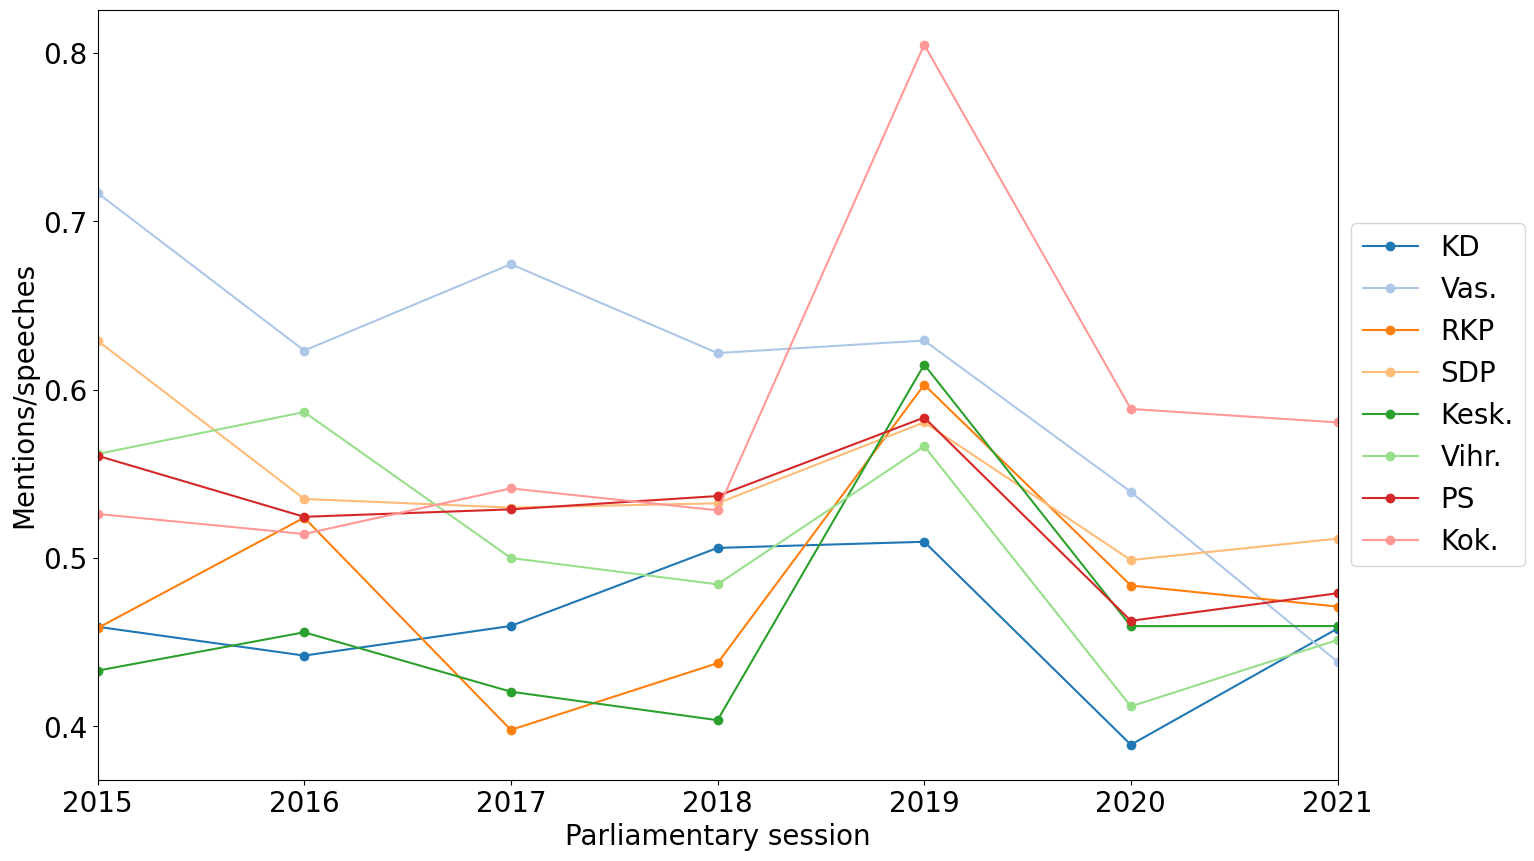

In [ ]:
NUM_COLORS = 20
cm = plt.get_cmap('tab20')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

x = [key for key in sorted(parls_mentions)][:-1]
ys = []

title = ''
#labels = parties
x_label = 'Parliamentary session'
y_label = 'Mentions/speeches'
parties2 = ['KD', 'Vas.', 'RKP', 'SDP', 'Kesk.', 'Vihr.', 'PS', 'Kok.']

fig = plt.figure(figsize=[16.0, 10.0])

ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS)])
print(parties)
labels = []
for p in parties2:
  y = []
  x2 = []
  all_parls = True
  for x1 in x:
    try:
      y.append(parls_mentions[x1][p]['mentioner']/parls_mentions[x1][p]['speeches'])
      x2.append(x1)
    except KeyError:
      all_parls = False
  #if all_parls:
  labels.append(p)
  ax.plot(x2, y, marker='o')
  print(p, y)



#for y in ys:
#  print(y)
#  ax.plot(x, y, marker='o')

ax.autoscale(enable=True, axis='x', tight=True)
ax.legend(labels=labels,prop={'size': 20},loc='center left', bbox_to_anchor=(1, 0.5))
#ax.legend(labels=labels, loc='upper right',prop={'size': 20})
ax.set_title(title, fontsize=30)
ax.set_xlabel(x_label, fontsize=20)
ax.set_ylabel(y_label, fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.show()

## Mentions made by people with different roles (government, opposition)

Query speeches where member of government or opposition party has mentioned at least one MP. Speeches from officials are not taken into account.

In [ ]:
q = """
SELECT DISTINCT ?s ?parls ?role ?target ?party ?date {

  ?s a semparls:Subcorpus5 .

  ?s semparls:speechType ?type .
  FILTER (?type != <http://ldf.fi/semparl/speechtypes/PuhemiesPuheenvuoro>) .

  ?s dct:date ?date .
  #FILTER (?date <= '2019-04-22'^^xsd:date)

  ?s semparls:plenarySession/semparls:parliamentarySession ?session .
  ?session skos:prefLabel ?parls .
  FILTER(LANG(?parls)='fi')
  ?session semparls:electoralTerm eterms:e_2015-04-22-2019-04-16 .

  ?s dct:language <http://id.loc.gov/vocabulary/iso639-2/fin> .

  ?s semparls:parliamentaryRole ?group .
  ?group skos:prefLabel ?role .  #Hallituspuolue, Oppositiopuolue, Virkamies
  FILTER(LANG(?role)='fi')

  ?s semparls:speaker ?source .
  ?s semparl_linguistics:referenceToPerson/skos:relatedMatch ?target .
  FILTER(?source != ?target)

  # Party of the mentioned person (if none mention is not taken into account)
  ?target bioc:bearer_of/crm:P11i_participated_in ?event .
  ?event a semparls:ParliamentaryGroupMembership .
  ?event crm:P10_falls_within eterms:e_2015-04-22-2019-04-16 .
  ?event semparls:organization/rdfs:subClassOf/semparls:party ?party .
  ?event crm:P4_has_time-span ?tspant .
  ?tspant crm:P81a_begin_of_the_begin ?t_startt .
  OPTIONAL { ?tspant crm:P82b_end_of_the_end ?t_endt }
  FILTER (?t_startt <= ?date && (!BOUND(?t_endt) || ?t_endt >= ?date))

  FILTER(?party != groups:Q30337076 || (?party=groups:Q30337076 && ?date >= "2017-06-13"^^xsd:date))

}

"""
sparql = SPARQLWrapper(ENDPOINT)

sparql.setReturnFormat(JSON)
sparql.setMethod(POST)
sparql.setQuery(PREFIXES + q)
results = sparql.query().convert()

vars = results['head']['vars']

res_nodes = convertDatatypes(results)
print(len(res_nodes))


37111


In [ ]:
res_nodes[:5]

[{'s': 'http://ldf.fi/semparl/speeches/s2015_1_013_007',
  'parls': 'Valtiopäivät 2015',
  'role': 'Oppositiopuolue',
  'target': 'http://ldf.fi/semparl/people/p1108',
  'party': 'http://ldf.fi/semparl/groups/Q506591',
  'date': datetime.date(2015, 6, 2)},
 {'s': 'http://ldf.fi/semparl/speeches/s2015_1_013_008',
  'parls': 'Valtiopäivät 2015',
  'role': 'Oppositiopuolue',
  'target': 'http://ldf.fi/semparl/people/p767',
  'party': 'http://ldf.fi/semparl/groups/Q634277',
  'date': datetime.date(2015, 6, 2)},
 {'s': 'http://ldf.fi/semparl/speeches/s2015_1_013_008',
  'parls': 'Valtiopäivät 2015',
  'role': 'Oppositiopuolue',
  'target': 'http://ldf.fi/semparl/people/p1274',
  'party': 'http://ldf.fi/semparl/groups/Q499029',
  'date': datetime.date(2015, 6, 2)},
 {'s': 'http://ldf.fi/semparl/speeches/s2015_1_013_009',
  'parls': 'Valtiopäivät 2015',
  'role': 'Oppositiopuolue',
  'target': 'http://ldf.fi/semparl/people/p1108',
  'party': 'http://ldf.fi/semparl/groups/Q506591',
  'date': d

In [ ]:
# Electoral term 2015-2018
government = ['http://ldf.fi/semparl/groups/Q30337076', 'http://ldf.fi/semparl/groups/Q506591','http://ldf.fi/semparl/groups/Q304191']
# 2017-2018 (The Finns Party is no longer in the government)
finns = 'http://ldf.fi/semparl/groups/Q634277'
finn_date = date(2017,5,12)

In [ ]:
ho_mentions = {}
for ob in res_nodes:
  key = int(ob['parls'].split(" ")[-1])
  if key not in ho_mentions:
    ho_mentions[key] = {'hh':0, 'ho':0, 'oo':0, 'oh':0}
  if ob['party'] in government:
    target_role = 'Hallituspuolue'
  elif ob['party'] == 'http://ldf.fi/semparl/groups/Q634277' and ob['date'] <= finn_date:
    target_role = 'Hallituspuolue'
  else:
    target_role = 'Oppositiopuolue'
  if ob['role'] == target_role == 'Hallituspuolue':
    ho_mentions[key]['hh'] += 1 #ob['speeches']
  elif ob['role'] == target_role == 'Oppositiopuolue':
    ho_mentions[key]['oo'] += 1 #ob['speeches']
  elif ob['role'] == 'Hallituspuolue' and target_role == 'Oppositiopuolue':
    ho_mentions[key]['ho'] += 1 #ob['speeches']
  elif target_role == 'Hallituspuolue' and ob['role'] == 'Oppositiopuolue':
    ho_mentions[key]['oh'] += 1 #ob['speeches']



ho_mentions

{2015: {'hh': 1514, 'ho': 1703, 'oo': 900, 'oh': 2442},
 2016: {'hh': 2727, 'ho': 2640, 'oo': 1353, 'oh': 3171},
 2017: {'hh': 2696, 'ho': 2776, 'oo': 1276, 'oh': 2833},
 2018: {'hh': 3170, 'ho': 3302, 'oo': 1708, 'oh': 2883}}

In [ ]:
speeches_o = 0
speeches_h = 0
speeches_t = 0

for p in ho_mentions:
  po = ho_mentions[p]['oo'] + ho_mentions[p]['oh']
  ph = ho_mentions[p]['hh'] + ho_mentions[p]['ho']
  speeches_o += po
  speeches_h += ph
  speeches_t += po + ph
  ho_mentions[p]['total_o'] = po
  ho_mentions[p]['total_h'] = ph
  ho_mentions[p]['total'] = po + ph

  too = ho_mentions[p]['oo'] + ho_mentions[p]['ho']
  toh = ho_mentions[p]['hh'] + ho_mentions[p]['oh']

  ho_mentions[p]['mento_o'] = too
  ho_mentions[p]['mento_h'] = toh
  #ho_mentions[p]['mentotal'] = tof + tom # same as total

print("Mentions by opposition:", speeches_o)
print("Mentions by government:", speeches_h)
print("Total mentions:", speeches_t)

Mentions by opposition: 16566
Mentions by government: 20528
Total mentions: 37094


In [ ]:
q = """
# Opposition ja hallituksen puhemäärät
SELECT DISTINCT ?parls ?role (COUNT(DISTINCT ?s) AS ?speeches) {

    ?s a semparls:Subcorpus5 .  #Puheet valtiopäiviltä 2015-nykyhetki
    ?s semparls:speechType ?type .
    FILTER (?type != <http://ldf.fi/semparl/speechtypes/PuhemiesPuheenvuoro>) .    # Suodata puheenmiehen puheenvuorot
    ?s dct:language <http://id.loc.gov/vocabulary/iso639-2/fin> .                  # Suomen kieliset puheet
    ?s semparls:plenarySession/semparls:parliamentarySession ?session .
    ?session skos:prefLabel ?parls .
    FILTER(LANG(?parls)='fi')
    ?session semparls:electoralTerm eterms:e_2015-04-22-2019-04-16 .

    ?s semparls:parliamentaryRole ?group .
    ?group skos:prefLabel ?role .  #Hallituspuolue, Oppositiopuolue, Virkamies
    FILTER(LANG(?role)='fi')

} GROUP BY ?parls ?role

"""
sparql = SPARQLWrapper(ENDPOINT)

sparql.setReturnFormat(JSON)
sparql.setMethod(POST)

sparql.setQuery(PREFIXES + q)
results = sparql.query().convert()

vars = results['head']['vars']

res_nodes = convertDatatypes(results)
print(len(res_nodes))


12


In [ ]:
speeches_o = 0
speeches_h = 0
speeches_t = 0


for ob in res_nodes:
  key = int(ob['parls'].split(" ")[-1])
  if ob['role'] == 'Oppositiopuolue':
    ho_mentions[key]['speeches_o'] = ob['speeches']
    speeches_o += ob['speeches']
  elif ob['role'] == 'Hallituspuolue':
    ho_mentions[key]['speeches_h'] = ob['speeches']
    speeches_h += ob['speeches']

for key in ho_mentions:
  ho_mentions[key]['speeches_t'] = ho_mentions[key]['speeches_o'] + ho_mentions[key]['speeches_h']


print("Speeches by opposition:", speeches_o)
print("Speeches by government:", speeches_h)
print("Total speeches:", speeches_o+speeches_h)

Speeches by opposition: 23351
Speeches by government: 27753
Total speeches: 51104


In [ ]:
# Now parls_speeches dictionary of parliagovernmenttary session dictionaries, where
# speeches_t = total number of speeches
# speeches_o = total number of speeches given by females
# speeches_h = total number of speeches given by males
# total      = total number of mentions made during parliamentary session
# total_o    = total number of mentions made by opposition
# total_h    = total number of mentions made by government
# mento_o    = total number of mentions to opposition
# mento_h    = total number of mentions to government
# oo         = mentions from opposition to opposition
# oh         = mentions from opposition to government
# hh         = mentions from government to government
# ho         = mentions from government to opposition
ho_mentions

{2015: {'hh': 1514,
  'ho': 1703,
  'oo': 900,
  'oh': 2442,
  'total_o': 3342,
  'total_h': 3217,
  'total': 6559,
  'mento_o': 2603,
  'mento_h': 3956,
  'speeches_o': 4208,
  'speeches_h': 4378,
  'speeches_t': 8586},
 2016: {'hh': 2727,
  'ho': 2640,
  'oo': 1353,
  'oh': 3171,
  'total_o': 4524,
  'total_h': 5367,
  'total': 9891,
  'mento_o': 3993,
  'mento_h': 5898,
  'speeches_h': 7198,
  'speeches_o': 6434,
  'speeches_t': 13632},
 2017: {'hh': 2696,
  'ho': 2776,
  'oo': 1276,
  'oh': 2833,
  'total_o': 4109,
  'total_h': 5472,
  'total': 9581,
  'mento_o': 4052,
  'mento_h': 5529,
  'speeches_h': 7423,
  'speeches_o': 6030,
  'speeches_t': 13453},
 2018: {'hh': 3170,
  'ho': 3302,
  'oo': 1708,
  'oh': 2883,
  'total_o': 4591,
  'total_h': 6472,
  'total': 11063,
  'mento_o': 5010,
  'mento_h': 6053,
  'speeches_o': 6679,
  'speeches_h': 8754,
  'speeches_t': 15433}}

[0.34582000913659205, 0.37885523756599054, 0.36319547352822307, 0.3621201736349098]
[0.38899040657834627, 0.3667685468185607, 0.3739727872827698, 0.3771989947452593]
[0.21387832699619772, 0.210289089213553, 0.21160862354892207, 0.25572690522533315]
[0.5803231939163498, 0.4928504818153559, 0.46981757877280267, 0.4316514448270699]


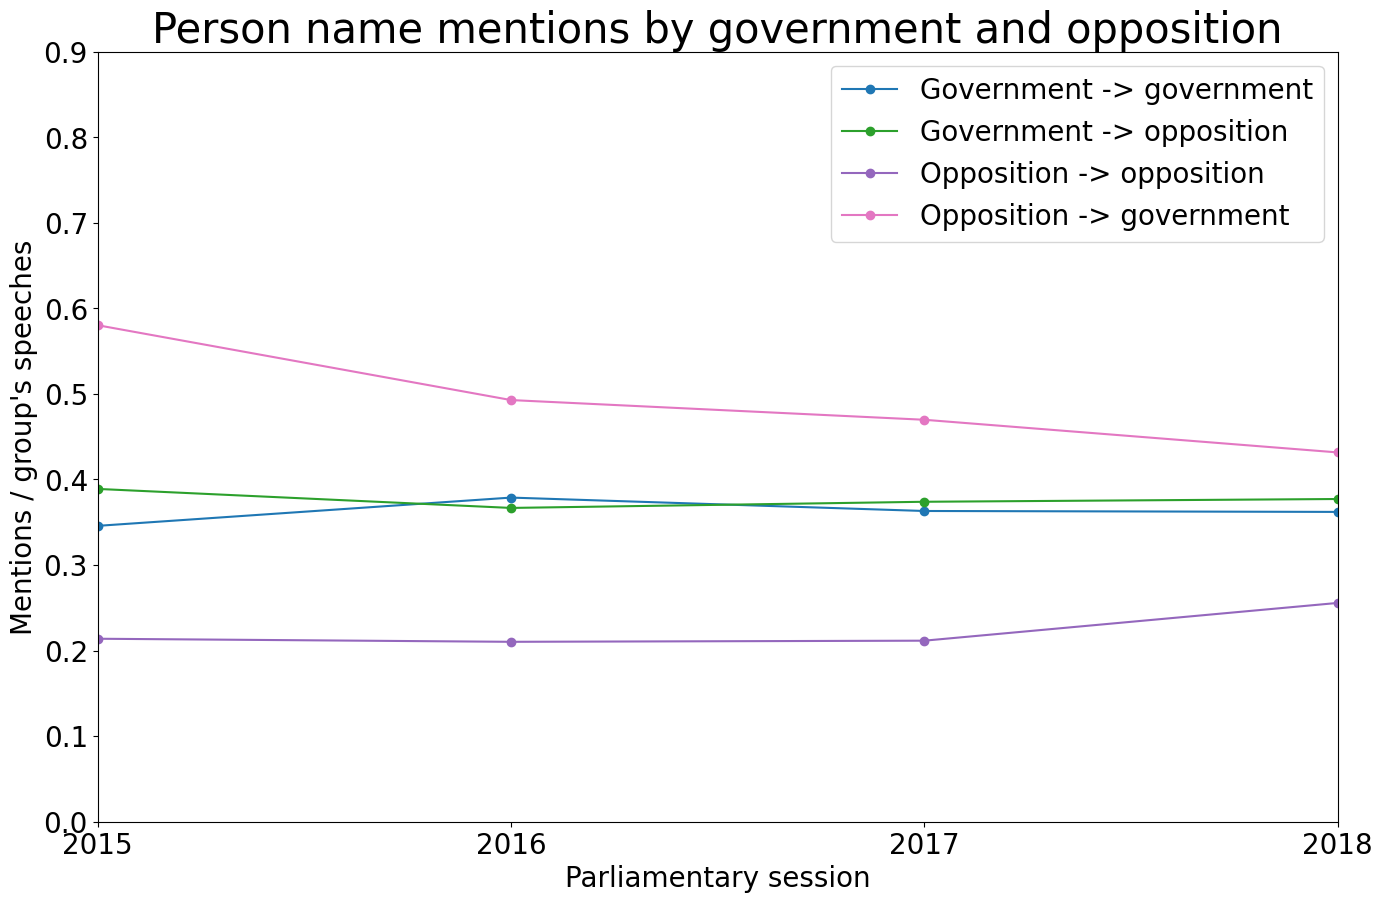

In [ ]:
NUM_COLORS = 6
cm = plt.get_cmap('tab20')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

x = [int(key) for key in sorted(ho_mentions)]
ys = []

title = 'Person name mentions by government and opposition'
labels = ['Government -> government', 'Government -> opposition', 'Opposition -> opposition', 'Opposition -> government']
x_label = 'Parliamentary session'
y_label = "Mentions / group's speeches"
ys.append([ ho_mentions[key]['hh']/ho_mentions[key]['speeches_h'] for key in x])
ys.append([ ho_mentions[key]['ho']/ho_mentions[key]['speeches_h'] for key in x])

ys.append([ ho_mentions[key]['oo']/ho_mentions[key]['speeches_o'] for key in x])
ys.append([ ho_mentions[key]['oh']/ho_mentions[key]['speeches_o'] for key in x])

#ys.append([ ho_mentions[key]['total_m']/ho_mentions[key]['speeches_m'] for key in x])
#ys.append([ ho_mentions[key]['total_f']/ho_mentions[key]['speeches_f'] for key in x])





fig = plt.figure(figsize=[16.0, 10.0])

ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS)])

for y in ys:
  print(y)
  ax.plot(x, y, marker='o')

ax.autoscale(enable=True, axis='x', tight=True)
#ax.legend(labels=labels,prop={'size': 20},loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(labels=labels, loc='upper right',prop={'size': 20})
ax.set_title(title, fontsize=30)
ax.set_xlabel(x_label, fontsize=20)
ax.set_ylabel(y_label, fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(x)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_ylim([0.0, 0.9])
plt.show()